In [1]:
import brian2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Neurons

Exact Integration

In [9]:
brian2.start_scope()

tau = 10*brian2.ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = brian2.NeuronGroup(1, eqs, method='exact')
print('Before v = %s' % G.v[0])
brian2.run(100*brian2.ms)
print('After v = %s' % G.v[0])
print('Expected value of v = %s' % (1-np.exp(-100*brian2.ms/tau)))

Before v = 0.0
After v = 0.9999546000702376
Expected value of v = 0.99995460007


Time-dependent activity

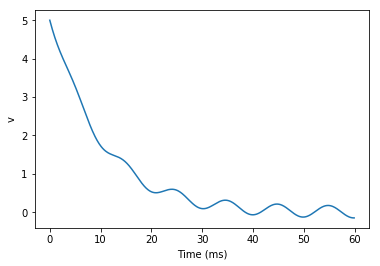

In [2]:
brian2.start_scope()

tau = 10*brian2.ms
eqs = '''
dv/dt = (sin(2*pi*100*Hz*t)-v)/tau : 1
'''

# Change to Euler method because exact integrator doesn't work here
G = brian2.NeuronGroup(1, eqs, method='euler')
M = brian2.StateMonitor(G, 'v', record=0)

G.v = 5 # initial value

brian2.run(60*brian2.ms)

brian2.plot(M.t/brian2.ms, M.v[0])
brian2.xlabel('Time (ms)')
brian2.ylabel('v');

Spiking, Refractoriness

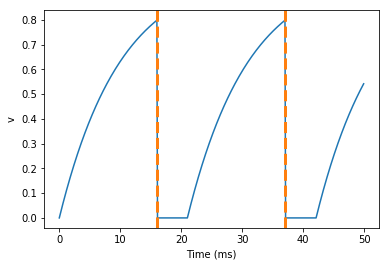

In [3]:
brian2.start_scope()

tau = 10*brian2.ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = brian2.NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*brian2.ms, method='exact')

statemon = brian2.StateMonitor(G, 'v', record=0)
spikemon = brian2.SpikeMonitor(G)

brian2.run(50*brian2.ms)

brian2.plot(statemon.t/brian2.ms, statemon.v[0])
for t in spikemon.t:
    brian2.axvline(t/brian2.ms, ls='--', c='C1', lw=3)
brian2.xlabel('Time (ms)')
brian2.ylabel('v');

Can also spike at the end of refractory period

Spike times: [  8.   23.1  38.2] ms


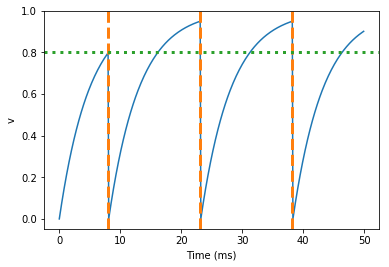

In [4]:
brian2.start_scope()

tau = 5*brian2.ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = brian2.NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=15*brian2.ms, method='exact')

statemon = brian2.StateMonitor(G, 'v', record=0)
spikemon = brian2.SpikeMonitor(G)

brian2.run(50*brian2.ms)

brian2.plot(statemon.t/brian2.ms, statemon.v[0])
for t in spikemon.t:
    brian2.axvline(t/brian2.ms, ls='--', c='C1', lw=3)
brian2.axhline(0.8, ls=':', c='C2', lw=3)
brian2.xlabel('Time (ms)')
brian2.ylabel('v')
print("Spike times: %s" % spikemon.t[:])

Multiple neurons. Note randomly initialized membrane potential

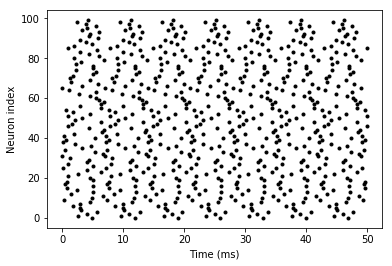

In [5]:
import brian2
brian2.start_scope()

N = 100
tau = 10*brian2.ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = brian2.NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'

spikemon = brian2.SpikeMonitor(G)

brian2.run(50*brian2.ms)

brian2.plot(spikemon.t/brian2.ms, spikemon.i, '.k')
brian2.xlabel('Time (ms)')
brian2.ylabel('Neuron index');

Parameters by index

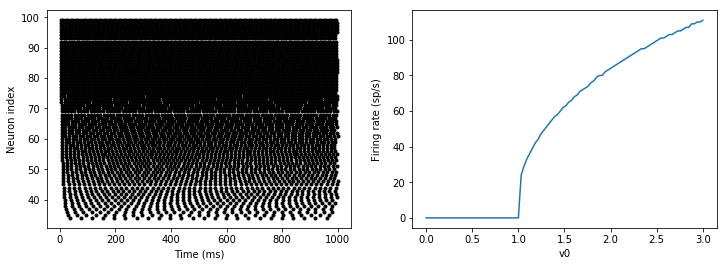

In [6]:
brian2.start_scope()

N = 100
tau = 10*brian2.ms
v0_max = 3.
duration = 1000*brian2.ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = brian2.NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*brian2.ms, method='exact')
M = brian2.SpikeMonitor(G)

#G.v = 'rand()'
G.v0 = 'i*v0_max/(N-1)'

brian2.run(duration)

brian2.figure(figsize=(12,4))
brian2.subplot(121)
brian2.plot(M.t/brian2.ms, M.i, '.k')
brian2.xlabel('Time (ms)')
brian2.ylabel('Neuron index')
brian2.subplot(122)
brian2.plot(G.v0, M.count/duration)
brian2.xlabel('v0')
brian2.ylabel('Firing rate (sp/s)');

Random Element to membrane potential dynamics

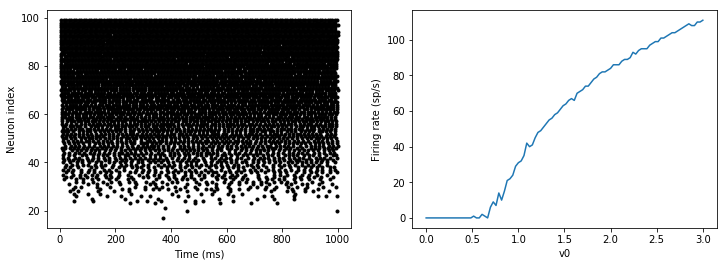

In [8]:
brian2.start_scope()

N = 100
tau = 10*brian2.ms
v0_max = 3.
duration = 1000*brian2.ms
sigma = 0.2

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = brian2.NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*brian2.ms, method='euler')
M = brian2.SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

brian2.run(duration)

brian2.figure(figsize=(12,4))
brian2.subplot(121)
brian2.plot(M.t/brian2.ms, M.i, '.k')
brian2.xlabel('Time (ms)')
brian2.ylabel('Neuron index')
brian2.subplot(122)
brian2.plot(G.v0, M.count/duration)
brian2.xlabel('v0')
brian2.ylabel('Firing rate (sp/s)');

# 2 Synapses

First example: 1st neuron depolarises the 2nd neuron a little bit every time it spikes

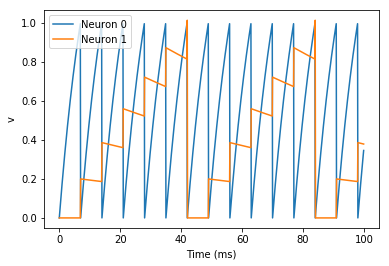

In [12]:
brian2.start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = brian2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')

# Define parameters for each of 2 neurons
G.I = [2, 0]
G.tau = [10, 100]*brian2.ms

# Comment these two lines out to see what happens without Synapses
S = brian2.Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = brian2.StateMonitor(G, 'v', record=True)

brian2.run(100*brian2.ms)

brian2.plot(M.t/brian2.ms, M.v[0], label='Neuron 0')
brian2.plot(M.t/brian2.ms, M.v[1], label='Neuron 1')
brian2.xlabel('Time (ms)')
brian2.ylabel('v')
brian2.legend();

Second Example: Have 2 excitatory connections with different synaptic weights and synaptic delays

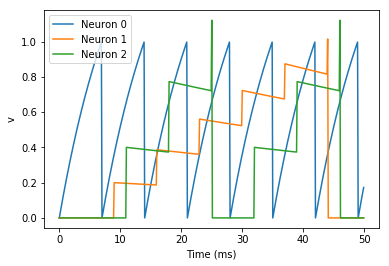

In [16]:
brian2.start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = brian2.NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*brian2.ms

# Comment these two lines out to see what happens without Synapses
S = brian2.Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = brian2.StateMonitor(G, 'v', record=True)

brian2.run(50*brian2.ms)

brian2.plot(M.t/brian2.ms, M.v[0], label='Neuron 0')
brian2.plot(M.t/brian2.ms, M.v[1], label='Neuron 1')
brian2.plot(M.t/brian2.ms, M.v[2], label='Neuron 2')
brian2.xlabel('Time (ms)')
brian2.ylabel('v')
brian2.legend();

Generating random connectivity

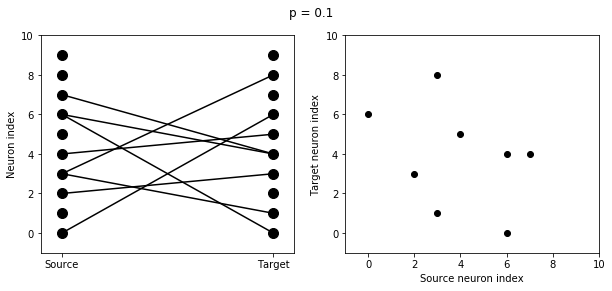

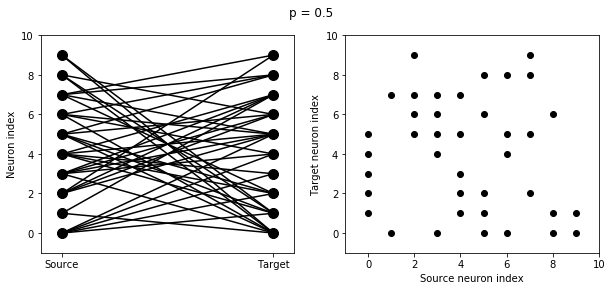

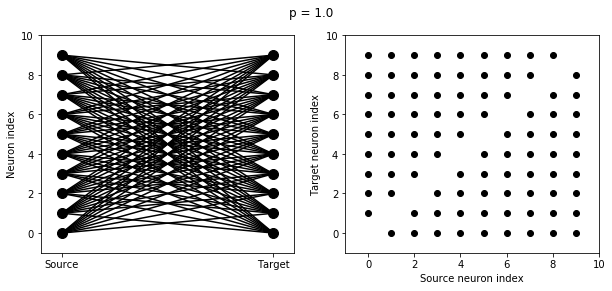

In [22]:
brian2.start_scope()

N = 10
G = brian2.NeuronGroup(N, 'v:1')

def visualise_connectivity(S):
    Ns = len(S.source)  # Number of source neurons
    Nt = len(S.target)  # Number of target neurons
    brian2.figure(figsize=(10, 4))
    brian2.subplot(121)
    brian2.plot(brian2.zeros(Ns), brian2.arange(Ns), 'ok', ms=10)  # place all sources at x=0
    brian2.plot(brian2.ones(Nt), brian2.arange(Nt), 'ok', ms=10)   # place all targets at x=0
    for i, j in zip(S.i, S.j):
        brian2.plot([0, 1], [i, j], '-k')  # Connect each source and target by lines
    brian2.xticks([0, 1], ['Source', 'Target'])
    brian2.ylabel('Neuron index')
    brian2.xlim(-0.1, 1.1)
    brian2.ylim(-1, max(Ns, Nt))
    
    # Plot connectivity matrix as a scatter plot
    brian2.subplot(122)
    brian2.plot(S.i, S.j, 'ok')
    brian2.xlim(-1, Ns)
    brian2.ylim(-1, Nt)
    brian2.xlabel('Source neuron index')
    brian2.ylabel('Target neuron index')

for p in [0.1, 0.5, 1.0]:
    S = brian2.Synapses(G, G)
    S.connect(condition='i!=j', p=p)  # Connect each neuron with a proportion of other neurons at random.
    visualise_connectivity(S)
    brian2.suptitle('p = '+str(p))

Generating non-random connectivity

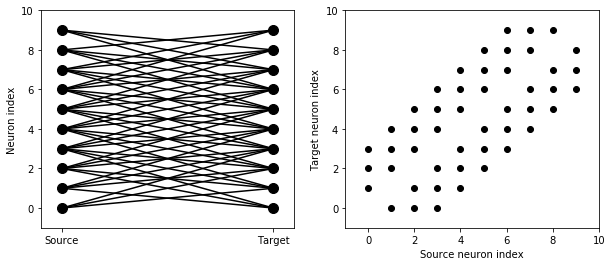

In [24]:
brian2.start_scope()

N = 10
G = brian2.NeuronGroup(N, 'v:1')

S = brian2.Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

Weights as strings. Define a position variable for each neuron. Make weight dependent on position of pre and post-synaptic neurons.

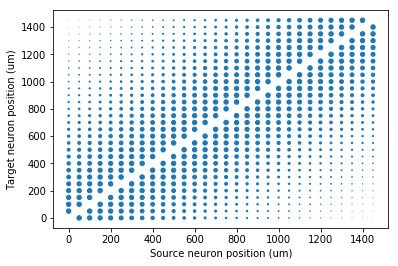

In [25]:
brian2.start_scope()

N = 30
neuron_spacing = 50*brian2.umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = brian2.NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = brian2.Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

brian2.scatter(S.x_pre/brian2.um, S.x_post/brian2.um, S.w*20)
brian2.xlabel('Source neuron position (um)')
brian2.ylabel('Target neuron position (um)');